# Gender representation in movies

### Modules 

In [1]:
# Load pkgs
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' # to adress problem with chian assignment .loc
import numpy as np

In [2]:
# Load Data Viz Pkgs 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Text mining and clening
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

In [4]:
# Word embedding
from gensim.models import Word2Vec

In [5]:
sw = stopwords.words('english')

## 1. Creating a gender-movie lines dataset   

<div class=text-justify> 
    
+ 1.1 importing the character dataset - fields: characterID, character name, movieID, movie title, gender ("?" for unlabeled cases), position in credits ("?" for unlabeled cases) - to get the gender infortmation
+ 1.2 importing the lines dataset - fields: lineID, characterID (who uttered this phrase), movieID, character name, text of the utterance - to get the lines of dialogues
+ 1.3 merging the two dataset to associate to each line the corresponding gender 
    </div>

### 1.1 Importing the movie characters dataset

In [17]:
characters_df = pd.read_csv('./data/movie_characters_metadata.tsv', sep='\t', on_bad_lines='skip', header=None)

In [18]:
# Renaming column names¶
characters_df.columns = ['chId','chName','mId','mTitle','gender','posCredits']

In [19]:
characters_df.head()

,chId,chName,mId,mTitle,gender,posCredits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,m,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,f,?
4,u4,JOEY,m0,10 things i hate about you,m,6


### 1.2 Importing the movie lines dataset 

In [20]:
lines_df = pd.read_csv('./data/movie_lines.tsv', sep='\t', on_bad_lines='skip', header=None)

In [21]:
# Renaming column names¶
lines_df.columns = ['lineId', 'chId', 'mId', 'chName', 'dialogue']

In [22]:
lines_df.head()

,lineId,chId,mId,chName,dialogue
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [23]:
lines_df.shape

(293202, 5)

### 1.3 Merging datasets to create a new dataset combining dialogue and gender data 

In [24]:
df = pd.merge(lines_df, characters_df, how='inner', on=['chId','mId', 'chName'],
         left_index=False, right_index=False, sort=True,
         copy=False, indicator=False)
df.head()

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,f,4
1,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,f,4
2,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,f,4
3,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,f,4
4,L869,u0,m0,BIANCA,Like my fear of wearing pastels?,10 things i hate about you,f,4


## 2 Exploring the new dataset  to fix problems within categorical variables¶
+ 2.1 exploring further the categorical data more relevant to task
  + 2.1.1 exploring chName data
  + 2.1.2 exploring dialogue data
  + 2.1.3 exploring gender data
+ 2.2 Filling in gender info not available using a name_gender dataset 
  + 2.2.1 loading and explorint the name_gender dataset
  + 2.2.2 creating a new colum of the df with the gender info of the name_dataset
  + 2.2.3 creating a new colum of the df combining the gender info of the name_dataset and the previous gender info

In [25]:
df.head()

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,f,4
1,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,f,4
2,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,f,4
3,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,f,4
4,L869,u0,m0,BIANCA,Like my fear of wearing pastels?,10 things i hate about you,f,4


In [26]:
df.shape

(288447, 8)

In [27]:
df.columns 

Index(['lineId', 'chId', 'mId', 'chName', 'dialogue', 'mTitle', 'gender',
       'posCredits'],
      dtype='object')

In [28]:
# view summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288447 entries, 0 to 288446
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lineId      288447 non-null  object
 1   chId        288447 non-null  object
 2   mId         288447 non-null  object
 3   chName      288404 non-null  object
 4   dialogue    288193 non-null  object
 5   mTitle      288447 non-null  object
 6   gender      288447 non-null  object
 7   posCredits  288447 non-null  object
dtypes: object(8)
memory usage: 19.8+ MB


In [29]:
# categorical variables
categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are :\n\n', categorical)

There are 8 categorical variables

The categorical variables are :

 ['lineId', 'chId', 'mId', 'chName', 'dialogue', 'mTitle', 'gender', 'posCredits']


In [30]:
# check for cardinality in categorical variables
for var in categorical:    
    print(var, ' contains ', len(df[var].unique()), ' labels')

lineId  contains  288447  labels
chId  contains  8749  labels
mId  contains  606  labels
chName  contains  5210  labels
dialogue  contains  250888  labels
mTitle  contains  606  labels
gender  contains  5  labels
posCredits  contains  57  labels


In [31]:
# numerical variables if any
numerical = [var for var in df.columns if df[var].dtype!='O']
print('There are {} numerical variables\n'.format(len(numerical)))
print('The numerical variables are :', numerical)

There are 0 numerical variables

The numerical variables are : []


In [32]:
df.duplicated().sum() #check duplicates 

0

In [33]:
df.isnull().sum()

lineId          0
chId            0
mId             0
chName         43
dialogue      254
mTitle          0
gender          0
posCredits      0
dtype: int64

## 2.1 exploring further the categorical data more relevant to task
+ chName
+ dialogue
+ gender

### 2.1.1 exploring chName data

In [34]:
# checking frequency distribution of values in chName data
df.chName.value_counts()

JACK             2874
JOE              1879
GEORGE           1690
FRANK            1489
SAM              1463
                 ... 
SOURPUSS            1
STREET VENDOR       1
SEN. MARTIN         1
DANKER              1
SAM AS JULIET       1
Name: chName, Length: 5209, dtype: int64

In [35]:
#checking whether there are ? 
df [df.chName == '?']

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits


In [36]:
#check on null ChName records to see whether it makes sense to keep them 
df[df['chName'].isnull()].head()

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits
100542,L50228,u3764,m248,NaN,215 CONTINUED:,arctic blue,?,?
100543,L50147,u3764,m248,NaN,175 CONTINUED:,arctic blue,?,?
100544,L50054,u3764,m248,NaN,150 CONTINUED:,arctic blue,?,?
100545,L50011,u3764,m248,NaN,139 CONTINUED:,arctic blue,?,?
100546,L50007,u3764,m248,NaN,134 CONTINUED:,arctic blue,?,?


In [37]:
# eliminating them as they don't say much about gender or dialogues
df = df [df['chName'].notnull()] 
df.shape

(288404, 8)

### 2.1.2 exploring dialogue data

In [38]:
# checking frequency distribution of values in dialogue data
df.dialogue.value_counts()

What?                                                           1610
Yes.                                                            1262
No.                                                             1256
Yeah.                                                            889
Why?                                                             540
                                                                ... 
Nothing's happening!                                               1
Why isn't it doing anything!?                                      1
Cure!? Ha-ha-ha!                                                   1
Another step and he's dead!                                        1
Agent Chase does it appear that they are heading for Mexico.       1
Name: dialogue, Length: 250845, dtype: int64

In [39]:
#checking whether there are ? 
df [df.dialogue == '?']

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits


In [40]:
#check on null dialogue records to see whether it makes sense to keep them 
df[df['dialogue'].isnull()].head()

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits
5022,L239088,u1125,m74,JANOSZ,NaN,ghostbusters ii,m,8
13859,L283548,u1356,m90,BRUCE,NaN,his girl friday,m,3
19035,L303243,u1475,m100,JOE,NaN,innerspace,M,?
42890,L24609,u224,m14,SYKES,NaN,alien nation,m,1
67870,L535288,u2919,m192,KRUGE,NaN,star trek iii: the search for spock,?,?


In [41]:
# eliminating them
df = df [df['dialogue'].notnull()] 
df.shape

(288150, 8)

### 2.1.3 exploring gender data

In [42]:
# checking frequency distribution of values in gender data
df.gender.value_counts()

m    145848
f     63303
?     59022
M     15399
F      4578
Name: gender, dtype: int64

In [43]:
df['gender'].replace('?', np.NaN, inplace=True) # trasforming ? in NaN to deal with them later

In [44]:
df.isnull().sum()

lineId            0
chId              0
mId               0
chName            0
dialogue          0
mTitle            0
gender        59022
posCredits        0
dtype: int64

<AxesSubplot:>

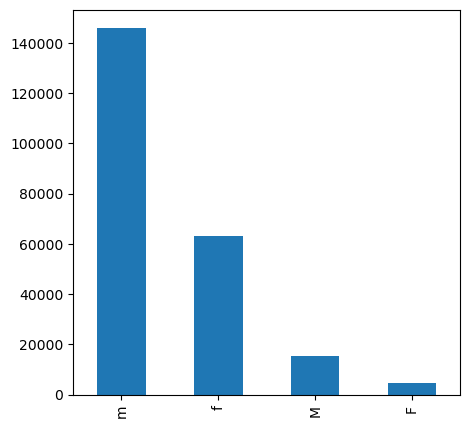

In [45]:
# visualizing gender data
plt.figure(figsize=(5,5))
df["gender"].value_counts().plot(kind='bar')

## 2.2 Integrate gender info using a name_gender dataset 

### 2.2.1 Loading and exploring the name_gender dataset

In [46]:
df_names = pd.read_csv('./data/name_gender_dataset.csv')

In [47]:
df_names.head()

,Name,Gender,Count,Probability
0,James,M,5304407,0.014517
1,John,M,5260831,0.014398
2,Robert,M,4970386,0.013603
3,Michael,M,4579950,0.012534
4,William,M,4226608,0.011567


In [48]:
df_names.isnull().sum()

Name           0
Gender         0
Count          0
Probability    0
dtype: int64

In [49]:
df_names.shape

(147269, 4)

In [50]:
df_names['Gender'].value_counts()

F    89749
M    57520
Name: Gender, dtype: int64

In [51]:
df_names.loc[df_names['Name'] == 'James']  

,Name,Gender,Count,Probability
0,James,M,5304407,0.014517
1615,James,F,23963,0.000066


In [52]:
df_names['Name'].duplicated().sum()  

13359

these are those names with double probabilities used for training ML, for just integrating gender data I'll drop the lowest between F and M 

In [53]:
# trasforming the dataset with only the Count highest value for gender so to have just a record for each name 
df_names.sort_values(['Name', 'Count','Gender'], inplace=True, ascending=True) 
df_names = df_names.sort_values('Count', ascending=False).drop_duplicates('Name').sort_index()
df_names.head()

,Name,Gender,Count,Probability
0,James,M,5304407,0.014517
1,John,M,5260831,0.014398
2,Robert,M,4970386,0.013603
3,Michael,M,4579950,0.012534
4,William,M,4226608,0.011567


In [54]:
df_names.loc[df_names['Name'] == 'James'] 

,Name,Gender,Count,Probability
0,James,M,5304407,0.014517


In [55]:
#checking new db shape and duplicates 
print(df_names.shape)
df_names['Name'].duplicated().sum()

(133910, 4)


0

In [56]:
# creating a variable to store the records that lack gender info to get the names and try them on df_names
nan_gender = df[df['gender'].isna()]

In [57]:
dict_nan_gender = nan_gender['chName'].value_counts().to_dict()

In [58]:
dict_nan_gender
pd.Series(dict_nan_gender).head()

MAN       282
FRANK     230
WOMAN     217
JIMMY     193
MOTHER    191
dtype: int64

In [59]:
#checking on a few of the record with more occurrencies-lines of the df[Name] NaN values to see 
#if df_gnames can help to get the info by matching them 
df_names.loc[df_names['Name'] == 'Man'] #yes < M

,Name,Gender,Count,Probability
27261,Man,M,245,6.705010e-07


In [60]:
df_names.loc[df_names['Name'] == 'Woman'] #missing, I am going to fix this later

,Name,Gender,Count,Probability


In [61]:
df_names.loc[df_names['Name'] == 'Frank'] #yes > M

,Name,Gender,Count,Probability
50,Frank,M,924751,0.002531


In [62]:
df_names.loc[df_names['Name'] == 'Mother'] #missing, I am going to fix this later

,Name,Gender,Count,Probability


In [63]:
df_names.loc[df_names['Name'] == 'Father'] #mistake probably father is considered a F name, I'll fix it later

,Name,Gender,Count,Probability
120623,Father,F,1,2.736740e-09


In [64]:
df_names.loc[df_names['Name'] == 'Jimmy'] #yes > M

,Name,Gender,Count,Probability
253,Jimmy,M,291501,0.000798


### 2.2.2 creating a new colum of the df with the gender info of the name_dataset

In [65]:
df_names.Name = df_names.Name.apply(lambda x: x.lower()) # make the name lower case

In [66]:
df_names.head()

,Name,Gender,Count,Probability
0,james,M,5304407,0.014517
1,john,M,5260831,0.014398
2,robert,M,4970386,0.013603
3,michael,M,4579950,0.012534
4,william,M,4226608,0.011567


In [67]:
df.chName = df.chName.apply(lambda x: x.lower()) # make the name lower case 

In [68]:
df.head()

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits
0,L1045,u0,m0,bianca,They do not!,10 things i hate about you,f,4
1,L985,u0,m0,bianca,I hope so.,10 things i hate about you,f,4
2,L925,u0,m0,bianca,Let's go.,10 things i hate about you,f,4
3,L872,u0,m0,bianca,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,f,4
4,L869,u0,m0,bianca,Like my fear of wearing pastels?,10 things i hate about you,f,4


In [69]:
#creating a dictionary to be used to map gender into a new colums of the df
d = df_names.set_index('Name')['Gender'].to_dict()
pd.Series(d).head()

james      M
john       M
robert     M
michael    M
william    M
dtype: object

In [70]:
pd.Series(d).shape

(133910,)

the updating of the d dictionary below occurred in two different moments: the first with the error and the spotted names above, the second after having run the following cells, created a categorical "gender2" with new names values, merged with "gender" in a new categorical "gendersum" to combine info in df and extrapolating again the NaN to get an idea of which names were still not present, store them in a temp variable and come back here to update again the dict. I did not update all missing names but just the ones with more than 200 utterenes except for a few that I will explain later, besides I am sure there is a faster way to do this with ML and still looking into it

In [71]:
new_values = {'father':'M', 'woman': 'F', 'mother': 'F', 'mom': 'F', 'kelly houge': 'F', 'killaine':'M', 'spock': 'M','chekov': 'M','sulu':'M', 'superman': 'M', "man's voice" : 'M', 'wife': 'F', 'waitress': 'F', "kyle's mother": 'F', 'detective kincaid': 'M', 'waiter': 'M', "woman's voice": 'F', 'catwoman': 'F', 'dad': 'M', 'joker': 'M','clemenza': 'M', 'mrs. marsh':'F','grandfather george': 'F','old man': 'M', 'sheriff cobb': 'M','von strack':'M','mrs. baker':'F','mr. johnson':'M', 'schultz': 'M', 'rev. sullivan': 'M','rachel cooper': 'F', 'ms. jones': 'F', 'young man': 'M', 'mr. thomerson': 'M', 'mrs. bundy': 'F', 'mrs. schuyler': 'F','mrs. redi': 'M','mrs. caldwell': 'F', 'grandpa':'M', 'father lawrence': 'M', 'groucho': 'M', 'szpilman': 'M', 'schindler': 'M', 'grandfather': 'M', 'heroine': 'F','pendergast': 'M', 'mother superior': 'F','mother miriam': 'F'}
d.update(new_values)
pd.Series(d).head()

james      M
john       M
robert     M
michael    M
william    M
dtype: object

In [72]:
pd.Series(d).shape

(133957,)

In [73]:
# checking whether the new vales have been added correctly or not
key = 'father'
if key in d.keys():
    print(f"Value: '{key}' exists in dictionary")   #f stands for strings with repalcement fields
else:
    print(f"Value: '{key}' does not exists in dictionary") #yes

Value: 'father' exists in dictionary


In [74]:
# checking whether the error on father have been corrected or not
print(d['father']) #yes 

M


In [75]:
# creating a new column with the info from d
df['gender2'] = df['chName'].map(d)

In [76]:
df.head()

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits,gender2
0,L1045,u0,m0,bianca,They do not!,10 things i hate about you,f,4,F
1,L985,u0,m0,bianca,I hope so.,10 things i hate about you,f,4,F
2,L925,u0,m0,bianca,Let's go.,10 things i hate about you,f,4,F
3,L872,u0,m0,bianca,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,f,4,F
4,L869,u0,m0,bianca,Like my fear of wearing pastels?,10 things i hate about you,f,4,F


In [77]:
# check the presence of gender value in gender2 of one of the previously gender NaN value records
df.loc[df['chName'] == 'frank'].head(1)

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits,gender2
4972,L238746,u1122,m74,frank,Okay that's no problem.,ghostbusters ii,NaN,?,M


In [78]:
df.isnull().sum() # the idea is now to combine gender and gender2 info to reduce NaN

lineId            0
chId              0
mId               0
chName            0
dialogue          0
mTitle            0
gender        59022
posCredits        0
gender2       59034
dtype: int64

In [79]:
df.gender.value_counts()  # joining also in gender M for m,M and F for f,F

m    145848
f     63303
M     15399
F      4578
Name: gender, dtype: int64

In [80]:
df.gender2.value_counts()

M    152432
F     76684
Name: gender2, dtype: int64

### 2.2.3 creating a new colum of the df combining the gender info of the name_dataset and the previous genedr info

so I am going to create a third column combining the info of gender (joining m and M in M and f anf F in F) and gender2

In [81]:
def categorise(row):  
    if row['gender']== 'm' or row['gender2'] == 'M':
        return 'M'
    if row['gender']== 'f' or row['gender2'] == 'F':
        return 'F'
    if row['gender']== 'M' or row['gender2'] == 'M':
        return 'M'
    if row['gender']== 'F' or row['gender2'] == 'F':
        return 'F'

In [82]:
df['gendersum'] = df.apply(lambda row: categorise(row), axis=1)

In [83]:
df.head()

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits,gender2,gendersum
0,L1045,u0,m0,bianca,They do not!,10 things i hate about you,f,4,F,F
1,L985,u0,m0,bianca,I hope so.,10 things i hate about you,f,4,F,F
2,L925,u0,m0,bianca,Let's go.,10 things i hate about you,f,4,F,F
3,L872,u0,m0,bianca,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,f,4,F,F
4,L869,u0,m0,bianca,Like my fear of wearing pastels?,10 things i hate about you,f,4,F,F


comparing the three variable 

In [84]:
df.gender.value_counts()

m    145848
f     63303
M     15399
F      4578
Name: gender, dtype: int64

In [85]:
df.gender2.value_counts()

M    152432
F     76684
Name: gender2, dtype: int64

In [86]:
df.gendersum.value_counts()

M    188595
F     75637
Name: gendersum, dtype: int64

checking that gendersum got from gender2 those values previously not present in gender via mapping

In [87]:
df.loc[df['chName'] == 'jimmy'].head(1)

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits,gender2,gendersum
9003,L257414,u1221,m80,jimmy,Yeah. Oh and they messed up your kitchen pret...,halloween h20: 20 years later,NaN,?,M,M


checking that gendersum got from gender2 those values previously not present in gender via updating dict d

In [88]:
df.loc[df['chName'] == 'man'].head(1)

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits,gender2,gendersum
4184,L236689,u1101,m72,man,You don't know what you're talking about.,ghost world,NaN,?,M,M


and that the info in gender and not in gender2 where kept

In [89]:
df.loc[df['chName'] == 'mcmurphy'].head(1)

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits,gender2,gendersum
209838,L428856,u6921,m463,mcmurphy,Thank you ma'am.,one flew over the cuckoo's nest,m,21,NaN,M


[78-86] is a section I mentioned before that had been used to test and try checking Names of the still NaN records in gender 2 after the name_dataset-gender chName mapping try to focus on those records with more that 100 utterences and then in gendersum used to update progressively the dictiorary d hence gendersum with the help of temp2 

In [90]:
nan_gender2 = df[df['gender2'].isnull()]

In [91]:
nan_gender2.head()

,lineId,chId,mId,chName,dialogue,mTitle,gender,posCredits,gender2,gendersum
137,L227465,u1000,m65,mcgraw,Yeah and I'm gonna be right back at it tomorro...,from dusk till dawn,NaN,?,NaN,None
138,L227448,u1000,m65,mcgraw,They'll probably make a run for the border whi...,from dusk till dawn,NaN,?,NaN,None
139,L227447,u1000,m65,mcgraw,Four Rangers three cops and two civilians. And...,from dusk till dawn,NaN,?,NaN,None
140,L227445,u1000,m65,mcgraw,What the hell would I do with that grease pit?...,from dusk till dawn,NaN,?,NaN,None
141,L227443,u1000,m65,mcgraw,Well if there ain't there sure oughta be. Who ...,from dusk till dawn,NaN,?,NaN,None


In [92]:
dict_nan_gender2 = nan_gender2['chName'].value_counts().to_dict()

In [102]:
for key, value in dict_nan_gender2.items():
    if value >= 100:
        print(key, value)

picard 567
gittes 428
epps 400
lombard 348
dignan 347
bateman 334
mumford 326
venkman 305
mcmurphy 284
stew 280
whale 275
voice 271
longfellow 251
bernstein 242
mrs. robinson 237
anderton 234
cates 224
starks 212
salieri 204
delacroix 204
clerk 203
bones 197
mackelway 188
gump 184
ichabod 184
sykes 183
star man 181
basquiat 178
aaronow 173
klute 170
m.j. 169
kafka 161
sooze 158
creasy 158
kittle 157
sheldrake 156
fry 150
woodly 149
taupin 146
mccleod 144
james leer 144
jim kurring 143
stantz 137
pony 134
o'brien 133
paine 133
mr. white 133
almásy 132
wigand 132
david lee 131
tenzin gyatso 131
klaatu 130
mookie 129
bialystock 129
book 128
lambeau 126
concannon 126
doolittle 125
saavik 125
tubbs 125
o'connell 123
cardenas 122
j.d. 121
the kid 120
preysing 118
flaemmchen 118
kringelein 117
nuke 117
preacher 113
macfarlane 112
ramón 111
swana 111
gonzo 109
day-day 108
macready 107
constanze 106
coulmier 106
nurse 105
shinzon 104
z 104
major kong 102
crabtree 102
butt-head 102
brill 102
sca

In [103]:
nan_gendersum = df[df['gendersum'].isna()]

In [104]:
dict_nan_gendersum = nan_gendersum['chName'].value_counts().to_dict() 

In [105]:
pd.Series(dict_nan_gendersum).head()

voice       182
kittle      157
clerk       143
cardenas    122
preacher    113
dtype: int64

this is the actual result of the updating of d dispaying now the fewer entries left out, there are just few with more than 100 utterences that in most case are related to mixed character from different movies like clearks or voice

In [106]:
for key, value in dict_nan_gendersum.items():
    if value >= 100:
        print(key, value)

voice 182
kittle 157
clerk 143
cardenas 122
preacher 113
ramón 111


In [107]:
new_values  # these are the value i entered to update manually gendersum

{'father': 'M',
 'woman': 'F',
 'mother': 'F',
 'mom': 'F',
 'kelly houge': 'F',
 'killaine': 'M',
 'spock': 'M',
 'chekov': 'M',
 'sulu': 'M',
 'superman': 'M',
 "man's voice": 'M',
 'wife': 'F',
 'waitress': 'F',
 "kyle's mother": 'F',
 'detective kincaid': 'M',
 'waiter': 'M',
 "woman's voice": 'F',
 'catwoman': 'F',
 'dad': 'M',
 'joker': 'M',
 'clemenza': 'M',
 'mrs. marsh': 'F',
 'grandfather george': 'F',
 'old man': 'M',
 'sheriff cobb': 'M',
 'von strack': 'M',
 'mrs. baker': 'F',
 'mr. johnson': 'M',
 'schultz': 'M',
 'rev. sullivan': 'M',
 'rachel cooper': 'F',
 'ms. jones': 'F',
 'young man': 'M',
 'mr. thomerson': 'M',
 'mrs. bundy': 'F',
 'mrs. schuyler': 'F',
 'mrs. redi': 'M',
 'mrs. caldwell': 'F',
 'grandpa': 'M',
 'father lawrence': 'M',
 'groucho': 'M',
 'szpilman': 'M',
 'schindler': 'M',
 'grandfather': 'M',
 'heroine': 'F',
 'pendergast': 'M',
 'mother superior': 'F',
 'mother miriam': 'F'}

now I wanto to erase the now obsolete gender info, namely the former columns 'gender' and 'gender2'

In [108]:
df.drop(columns= "gender", inplace = True) 
df.drop(columns= "gender2", inplace = True)

In [109]:
# and rename the new one
df.rename(columns={'gendersum': 'gender'}, inplace=True) #inplace true to rename df and not a copy

In [110]:
df.head()

,lineId,chId,mId,chName,dialogue,mTitle,posCredits,gender
0,L1045,u0,m0,bianca,They do not!,10 things i hate about you,4,F
1,L985,u0,m0,bianca,I hope so.,10 things i hate about you,4,F
2,L925,u0,m0,bianca,Let's go.,10 things i hate about you,4,F
3,L872,u0,m0,bianca,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,4,F
4,L869,u0,m0,bianca,Like my fear of wearing pastels?,10 things i hate about you,4,F


In [111]:
df.isnull().sum() #re-checking null values, there still lots of NaN but less and less relevant 

lineId            0
chId              0
mId               0
chName            0
dialogue          0
mTitle            0
posCredits        0
gender        23918
dtype: int64

In [112]:
# eliminating them
df = df[df['gender'].notnull()]

In [113]:
df.isnull().sum() #re-checking null values

lineId        0
chId          0
mId           0
chName        0
dialogue      0
mTitle        0
posCredits    0
gender        0
dtype: int64

In [114]:
df.shape

(264232, 8)

In [115]:
# re-checking resulting gender data
df.gender.value_counts()

M    188595
F     75637
Name: gender, dtype: int64

<AxesSubplot:>

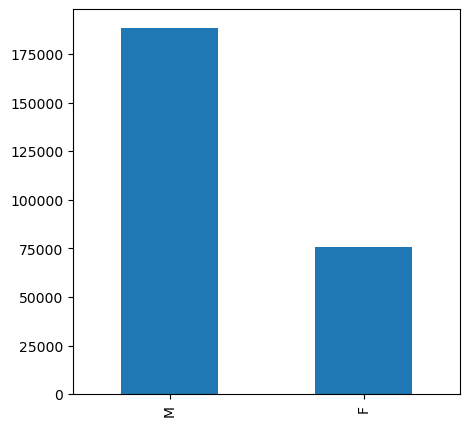

In [116]:
# visualizing resulting gender data
plt.figure(figsize=(5,5))
df["gender"].value_counts().plot(kind='bar')

## 3. Text cleaning

<div class=text-justify>
    
+ 3.1 creating a function of funcions to personalize text cleaning according to need
+ 3.2 removing missing values/empty strings, which Pandas doesn't recognise as null
    </div>

### 3.1 Creating a functon of funcions to personalize text clening according to need

In [117]:
def remove_punct(text):
    temp = re.sub('[=.()[!?]', ' ', text) # re \?optional character, *zero or more repetition
    text = re.sub('\[.*?\]',' ', temp)
    return text

def stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text=' '.join([ps.stem(word) for word in text.split()])
    return text

def remove_tags(text):
    return re.sub(r"@\S+", "", text)

def remove_url(text):
    return re.sub(r"http\S+", "",text)
     
def final_clean_SW(text): #taking away stop words 
    final_text= []
    for i in text.split():
        if i.strip().lower() not in sw and i.strip().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

def final_clean_AFFSW(text): #taking away just affirmative stop words 
    final_text= []
    for i in text.split():
        if i.strip().lower() not in affsw and i.strip().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

def final_clean(text): #keeping the stop words
    final_text= []
    for i in text.split():
        if i.strip().lower() and i.strip().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

In [118]:
negsw = ['no', 'nor', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't" ]
affsw = [word for word in sw if word not in negsw]

In [119]:
def clean(text):
    text = remove_punct(text)
    text = final_clean_AFFSW(text)
    #text = stemmer(text) 
    #text = remove_tags(text)
    #text = remove_url(text)
    #text = final_clean(text)
    return text

In [120]:
df['dialogue'] = df['dialogue'].apply(clean)

In [121]:
df.head()

,lineId,chId,mId,chName,dialogue,mTitle,posCredits,gender
0,L1045,u0,m0,bianca,not,10 things i hate about you,4,F
1,L985,u0,m0,bianca,hope,10 things i hate about you,4,F
2,L925,u0,m0,bianca,go,10 things i hate about you,4,F
3,L872,u0,m0,bianca,okay gonna need learn lie,10 things i hate about you,4,F
4,L869,u0,m0,bianca,like fear wearing pastels,10 things i hate about you,4,F


In [122]:
df.shape

(264232, 8)

In [123]:
df.isnull().sum()

lineId        0
chId          0
mId           0
chName        0
dialogue      0
mTitle        0
posCredits    0
gender        0
dtype: int64

### 3.2 removing missing values/empty strings, which Pandas doesn't recognise as null
#### to be used when stop words have been removed

In [124]:
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

In [125]:
df.head()

,lineId,chId,mId,chName,dialogue,mTitle,posCredits,gender
0,L1045,u0,m0,bianca,not,10 things i hate about you,4,F
1,L985,u0,m0,bianca,hope,10 things i hate about you,4,F
2,L925,u0,m0,bianca,go,10 things i hate about you,4,F
3,L872,u0,m0,bianca,okay gonna need learn lie,10 things i hate about you,4,F
4,L869,u0,m0,bianca,like fear wearing pastels,10 things i hate about you,4,F


In [126]:
df.shape

(251438, 8)

In [134]:
df.to_csv('./data/df_for_we.csv', index=False)

## 4. Word Embedding with Gensim

+ 4.1 training a base gender mixed model
+ 4.2 training two gender specialized models: "leia" trained on female lines and "luke" trained on male lines

### 4.1 base model 

In [127]:
lines = df['dialogue'].tolist()

In [128]:
lines[0]

'not'

In [129]:
len(lines)

251438

In [130]:
tokens = [[x for x in word_tokenize(t)] for t in lines]

In [131]:
model = Word2Vec(sentences=tokens, vector_size=100, 
                 window=6, epochs=20, min_count=1, workers=1, seed=1, hashfxn=hash) 

about parameters from Gensim documentation and #comment: 
+ sentences (iterable of iterables, optional) – The sentences iterable can be simply a list of lists of tokens, but for larger corpora, consider an iterable that streams the sentences directly from disk/network. 
+ vector_size (int, optional) – Dimensionality of the word vectors.
+ window (int, optional) – Maximum distance between the current and predicted word within a sentence.
+ epochs (int, optional) – Number of iterations (epochs) over the corpus. (Formerly: iter)
+ min_count (int, optional) – Ignores all words with total frequency lower than this.
+ workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines). 
+ seed (int, optional) – Seed for the random number generator. Initial vectors for each word are seeded with a hash of the concatenation of word + str(seed). Note that for a fully deterministically-reproducible run, you must also limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling. (In Python 3, reproducibility between interpreter launches also requires use of the PYTHONHASHSEED environment variable to control hash randomization).
+ hashfxn (function, optional) – Hash function to use to randomly initialize weights, for increased training reproducibility.

In [132]:
model.wv.similar_by_word('sun')

[('shine', 0.6823630928993225),
 ('sky', 0.6821581721305847),
 ('sea', 0.6738990545272827),
 ('mountains', 0.6375836133956909),
 ('darkness', 0.63669753074646),
 ('clouds', 0.6235483288764954),
 ('light', 0.6200230717658997),
 ('skies', 0.616614818572998),
 ('shining', 0.6165241003036499),
 ('wind', 0.6018227338790894)]

In [133]:
model.wv.similarity('sun', 'light')

0.6200231

### 4.2  Training two gender specialized models

In [114]:
lines_f = df[df['gender'] == 'F']['dialogue'].tolist()
lines_m = df[df['gender'] == 'M']['dialogue'].tolist()

In [115]:
len(lines_f)

71809

In [116]:
len(lines_m)

179629

**Training specialized model on female lines, named "leia"**

In [117]:
tokens_f = [[x for x in word_tokenize(t)] for t in lines_f]

In [118]:
leia = Word2Vec(sentences=tokens_f, vector_size=100, 
                 window=6, epochs=20, min_count=1, workers=1, seed=1, hashfxn=hash)

In [119]:
leia.wv.similar_by_word('sun')

[('shine', 0.8102126717567444),
 ('desert', 0.798184871673584),
 ('reservation', 0.7832241654396057),
 ('shines', 0.7584901452064514),
 ('conjuction', 0.7490602731704712),
 ('mansion', 0.7439008355140686),
 ('erik', 0.742368757724762),
 ('squalid', 0.7353989481925964),
 ('legs', 0.7325146198272705),
 ('tent', 0.7321624755859375)]

In [120]:
leia.wv.similarity('sun', 'light')

0.61100084

**Training a specialized model on male lines, named luke**

In [121]:
tokens_m = [[x for x in word_tokenize(t)] for t in lines_m]

In [122]:
luke = Word2Vec(sentences=tokens_m, vector_size=100, 
                 window=6, epochs=20, min_count=1, workers=1, seed=1, hashfxn=hash)

In [123]:
luke.wv.similar_by_word('sun')

[('wind', 0.6716731190681458),
 ('sky', 0.6704768538475037),
 ('tower', 0.6629658937454224),
 ('beneath', 0.6577014327049255),
 ('darkness', 0.6553227305412292),
 ('sea', 0.6548003554344177),
 ('clouds', 0.6481729745864868),
 ('stained', 0.6376938223838806),
 ('winter', 0.6260844469070435),
 ('tide', 0.6188468337059021)]

In [124]:
luke.wv.similarity('sun', 'light')

0.608419

## 5  Using leia e luke models to compare the semantic shift of words related to agentinc and communal contents
+ 5.1 Usign leia and luke to compare the semantic shift of words related to agentinc and communal contents
    + 5.1.1 Exploring semantic contex of words related to agentic content
    + 5.1.2 Exploring semantic contex of words related to communal content
    + 5.1.3 Exploring semantic contex of other related words
    + 5.1.4 Using the specialized models to compare the shift of specific words relations
    + 5.1.5 Using the specialized models to compare the shift of specific words analogies among words
    + 5.1.6 Using the specialized models to compare the shift on semantic mean among words

#### 5.1.1 Exploring semantic contex of words related to Agentic content

**DECISION**

In [125]:
model.wv.similar_by_word('decision') 

[('decisions', 0.7197191715240479),
 ('arrangements', 0.6749248504638672),
 ('exception', 0.6729210615158081),
 ('mistakes', 0.6341828107833862),
 ('smarted', 0.6293575763702393),
 ('recalcitrant', 0.6244298815727234),
 ('statement', 0.6187847852706909),
 ('proposition', 0.6170982718467712),
 ('sideration', 0.6155766248703003),
 ('threats', 0.6050094366073608)]

In [126]:
leia.wv.similar_by_word('decision') 

[('decisions', 0.8534195423126221),
 ('creations', 0.850827157497406),
 ('mistakes', 0.823603630065918),
 ('bergdorf', 0.8183647394180298),
 ('arrangements', 0.8180564641952515),
 ('uncomfortable', 0.8167127966880798),
 ('sacrifice', 0.8145965337753296),
 ('cinnamon', 0.8086382746696472),
 ('excuses', 0.8074338436126709),
 ('bigs', 0.8051620721817017)]

In [127]:
luke.wv.similar_by_word('decision') 

[('decisions', 0.7834005355834961),
 ('exception', 0.7350913882255554),
 ('mistakes', 0.7244989275932312),
 ('sideration', 0.7123640179634094),
 ('accusations', 0.6942721009254456),
 ('arrangements', 0.6778229475021362),
 ('inquiries', 0.6738249659538269),
 ('statement', 0.6631120443344116),
 ('judgments', 0.6504478454589844),
 ('hhhh', 0.6475404500961304)]

**Leader**

In [128]:
model.wv.similar_by_word('leader') 

[('rosette', 0.6524062156677246),
 ('litigator', 0.6373560428619385),
 ('macmillan', 0.6284849643707275),
 ('nation', 0.6247855424880981),
 ('drama', 0.6210361123085022),
 ('warrior', 0.6155075430870056),
 ('guatemala', 0.6148567199707031),
 ('anatomy', 0.6135656833648682),
 ('ent', 0.60845547914505),
 ('togetherness', 0.6074639558792114)]

In [129]:
leia.wv.similar_by_word('leader') 

[('corporal', 0.9399076700210571),
 ('vu', 0.9337121844291687),
 ('hallucinations', 0.9309984445571899),
 ('monroe', 0.9283525943756104),
 ('sooze', 0.9274176359176636),
 ('stratford', 0.9270815849304199),
 ('cor', 0.9266927242279053),
 ('seating', 0.9266908764839172),
 ('danke', 0.9254482984542847),
 ('groomsmen', 0.9253164529800415)]

In [130]:
luke.wv.similar_by_word('leader') 

[('litigator', 0.7071031928062439),
 ('dan', 0.7053254246711731),
 ('refutes', 0.699674665927887),
 ('craps', 0.6988564133644104),
 ('nicollet', 0.6927452087402344),
 ('quelled', 0.6779463887214661),
 ('assures', 0.6739602088928223),
 ('flaky', 0.6711775064468384),
 ('warrior', 0.669185996055603),
 ('discovery', 0.6669968366622925)]

**GAME**

In [131]:
model.wv.similar_by_word('game')

[('poker', 0.6414844393730164),
 ('games', 0.6213323473930359),
 ('ball', 0.6108510494232178),
 ('playing', 0.5868260264396667),
 ('score', 0.5813661217689514),
 ('football', 0.5682152509689331),
 ('player', 0.5583169460296631),
 ('baseball', 0.5533324480056763),
 ('league', 0.5341354012489319),
 ('play', 0.525000810623169)]

In [132]:
leia.wv.similar_by_word('game') 

[('play', 0.6818333864212036),
 ('semester', 0.6667368412017822),
 ('date', 0.6659095287322998),
 ('fallbrooks', 0.6656503081321716),
 ('blankets', 0.6652902364730835),
 ('line', 0.6646506786346436),
 ('teams', 0.6621901392936707),
 ('playing', 0.659890353679657),
 ('krikorian', 0.6578359007835388),
 ('option', 0.656433641910553)]

In [133]:
luke.wv.similar_by_word('game') 

[('poker', 0.6576982140541077),
 ('games', 0.6526516675949097),
 ('ball', 0.6479764580726624),
 ('player', 0.6122198104858398),
 ('playing', 0.609562337398529),
 ('football', 0.5922623872756958),
 ('score', 0.5821939706802368),
 ('league', 0.5638052821159363),
 ('baseball', 0.5617274045944214),
 ('lotto', 0.5580083131790161)]

**LAW**

In [134]:
model.wv.similar_by_word('law') 

[('enforcement', 0.746232807636261),
 ('interning', 0.6517430543899536),
 ('reiser', 0.6142669916152954),
 ('entrepreneurial', 0.577978253364563),
 ('constraint', 0.5661510229110718),
 ('expel', 0.5633748769760132),
 ('certificate', 0.5573444962501526),
 ('hotpants', 0.5473726987838745),
 ('anthology', 0.5393033623695374),
 ('university', 0.5392829179763794)]

In [135]:
leia.wv.similar_by_word('law') 

[('vigil', 0.8652543425559998),
 ('concubine', 0.8334420323371887),
 ('teaching', 0.8287087082862854),
 ('dropout', 0.8170924782752991),
 ('seniors', 0.811064600944519),
 ('accredited', 0.8077389001846313),
 ('ballard', 0.8058022856712341),
 ('ban', 0.8047893047332764),
 ('warner', 0.8044354915618896),
 ('bazaar', 0.8042718768119812)]

In [136]:
luke.wv.similar_by_word('law') 

[('enforcement', 0.7834931015968323),
 ('federal', 0.6550663113594055),
 ('interning', 0.6106180548667908),
 ('constraint', 0.6101337671279907),
 ('government', 0.602654218673706),
 ('state', 0.6001567840576172),
 ('official', 0.5880590081214905),
 ('exec', 0.5687916278839111),
 ('legal', 0.5635747909545898),
 ('jurisdiction', 0.562277615070343)]

**SPEAK**

In [137]:
model.wv.similar_by_word('speak')

[('spoken', 0.6269329190254211),
 ('english', 0.5304036736488342),
 ('speaks', 0.5252873301506042),
 ('gaelic', 0.4989660382270813),
 ('behaving', 0.4964793622493744),
 ('freely', 0.4896061420440674),
 ('kulok', 0.48512184619903564),
 ('interfere', 0.4837225675582886),
 ('repeat', 0.4822203516960144),
 ('chose', 0.4816245436668396)]

In [138]:
leia.wv.similar_by_word('speak')

[('attorney', 0.7715575695037842),
 ('thy', 0.7479707598686218),
 ('thou', 0.7469649910926819),
 ('shermin', 0.7328740954399109),
 ('fain', 0.7295507192611694),
 ('english', 0.7179030179977417),
 ('democracy', 0.7177442312240601),
 ('hadst', 0.7149208784103394),
 ('hast', 0.7105555534362793),
 ('honesty', 0.7083015441894531)]

In [139]:
luke.wv.similar_by_word('speak')

[('language', 0.5766578316688538),
 ('spoken', 0.5516214966773987),
 ('deny', 0.537286102771759),
 ('gaelic', 0.532784640789032),
 ('speaking', 0.5306099653244019),
 ('adopt', 0.517009973526001),
 ('mackelway', 0.5117287635803223),
 ('adequately', 0.5084408521652222),
 ('envoys', 0.5082011222839355),
 ('interfere', 0.5051628351211548)]

**POLITICS**

In [140]:
model.wv.similar_by_word('politics')

[('based', 0.6811329126358032),
 ('art', 0.6494126915931702),
 ('sexual', 0.6125303506851196),
 ('experiences', 0.6120377779006958),
 ('legal', 0.6115383505821228),
 ('scientific', 0.6066733002662659),
 ('culture', 0.594924807548523),
 ('interfere', 0.5910207033157349),
 ('science', 0.589777946472168),
 ('religious', 0.5882869958877563)]

In [141]:
leia.wv.similar_by_word('politics')

[('defense', 0.9306066632270813),
 ('incomprehensible', 0.9229183197021484),
 ('heartbreak', 0.9215785264968872),
 ('abolishment', 0.9208872318267822),
 ('quad', 0.9208745956420898),
 ('interpretation', 0.9186541438102722),
 ('sleaziest', 0.9181327223777771),
 ('apartheid', 0.9145314693450928),
 ('regulatory', 0.9140927195549011),
 ('tapestry', 0.9137299656867981)]

In [142]:
luke.wv.similar_by_word('politics')

[('subconscious', 0.6729413866996765),
 ('cynical', 0.6536476016044617),
 ('inclined', 0.6310921907424927),
 ('common', 0.6258177757263184),
 ('loosely', 0.6250626444816589),
 ('cruel', 0.6238190531730652),
 ('lack', 0.6216678619384766),
 ('ordinary', 0.6212913990020752),
 ('unfair', 0.6207675933837891),
 ('freedom', 0.6126900315284729)]

**ECONOMICS**

In [143]:
model.wv.similar_by_word('economics')

[('phuket', 0.7519070506095886),
 ('eater', 0.7387711405754089),
 ('physicists', 0.7374659180641174),
 ('chérie', 0.7322070002555847),
 ('apoc', 0.7310646176338196),
 ('brahms', 0.7237496972084045),
 ('commend', 0.720696210861206),
 ('capillary', 0.7202239036560059),
 ('reminders', 0.7195419669151306),
 ('dominique', 0.7190027236938477)]

leia.wv.similar_by_word('economics') # here she returns KeyError: "Key 'economics' not present"

In [144]:
luke.wv.similar_by_word('economics')

[('colleen', 0.795127809047699),
 ('contingencies', 0.7926405668258667),
 ('appipulai', 0.7925943732261658),
 ('lactose', 0.786105215549469),
 ('germ', 0.785918116569519),
 ('offerin', 0.7847583889961243),
 ('wannabee', 0.7806900143623352),
 ('pence', 0.7805798053741455),
 ('aaaank', 0.7787984609603882),
 ('croupier', 0.7769577503204346)]

#### 5.1.2 Exploring semantic contex of words related to communal content

**TRUST**

In [145]:
model.wv.similar_by_word('trust') 

[('trusted', 0.5230218768119812),
 ('faith', 0.49484074115753174),
 ('choose', 0.46691998839378357),
 ('honest', 0.4587436616420746),
 ('helped', 0.4499565064907074),
 ('personal', 0.44284331798553467),
 ('implicitly', 0.441128671169281),
 ('ancients', 0.44054579734802246),
 ('respect', 0.438378244638443),
 ('willing', 0.433566689491272)]

In [146]:
leia.wv.similar_by_word('trust') 

[('implicitly', 0.7619571089744568),
 ('ballplayer', 0.7313967347145081),
 ('simply', 0.7307876348495483),
 ('kickbacks', 0.7232261300086975),
 ('clambake', 0.722159206867218),
 ('feelings', 0.7113398313522339),
 ('hurt', 0.7056278586387634),
 ('stand', 0.700676679611206),
 ('romantically', 0.696991503238678),
 ('touch', 0.6966460943222046)]

In [147]:
luke.wv.similar_by_word('trust') 

[('trusted', 0.49073344469070435),
 ('hurt', 0.4789045751094818),
 ('choose', 0.4549924433231354),
 ('ancients', 0.44181346893310547),
 ('protect', 0.4392508268356323),
 ('simple', 0.4251670837402344),
 ('responsibility', 0.42467594146728516),
 ('understand', 0.4231102764606476),
 ('responsible', 0.4229015111923218),
 ('honest', 0.417562872171402)]

**UNDERSTAND**

In [148]:
model.wv.similar_by_word('understand')

[('understanding', 0.5034779906272888),
 ('know', 0.49283266067504883),
 ('satisfied', 0.4808705449104309),
 ('embarrassed', 0.4659891724586487),
 ('ignore', 0.46510598063468933),
 ('speak', 0.4632973372936249),
 ('responsible', 0.4619441032409668),
 ('dese', 0.4602375626564026),
 ('feelings', 0.4571031630039215),
 ('experience', 0.44959115982055664)]

In [149]:
leia.wv.similar_by_word('understand')

[('feelings', 0.7105677723884583),
 ('involved', 0.6907340884208679),
 ('personal', 0.6895884275436401),
 ('blame', 0.676398754119873),
 ('trust', 0.6755289435386658),
 ('reason', 0.6718007922172546),
 ('simply', 0.6631086468696594),
 ('paternal', 0.6341061592102051),
 ('shock', 0.6321044564247131),
 ('satisfaction', 0.632032573223114)]

In [150]:
luke.wv.similar_by_word('understand')

[('interfere', 0.4792768359184265),
 ('badly', 0.47918057441711426),
 ('important', 0.47691741585731506),
 ('agree', 0.47026556730270386),
 ('mysticism', 0.46927690505981445),
 ('normal', 0.46905994415283203),
 ('respect', 0.46855005621910095),
 ('knowing', 0.4683611989021301),
 ('understanding', 0.45780640840530396),
 ('braincase', 0.4567636251449585)]

**TEAM**

In [151]:
model.wv.similar_by_word('team')

[('pilots', 0.5449494123458862),
 ('denominators', 0.528906524181366),
 ('hyped', 0.5192335247993469),
 ('football', 0.5163095593452454),
 ('olympics', 0.5132482647895813),
 ('route', 0.511203944683075),
 ('extraction', 0.5043143033981323),
 ('army', 0.5040054321289062),
 ('squad', 0.5011851787567139),
 ('shuttle', 0.4974614679813385)]

In [152]:
leia.wv.similar_by_word('team') # to note: debate

[('debate', 0.8388311862945557),
 ('convenience', 0.790837287902832),
 ('football', 0.7882019877433777),
 ('plays', 0.7838284373283386),
 ('scottish', 0.7823089361190796),
 ('squares', 0.7816900014877319),
 ('magnet', 0.7784874439239502),
 ('consciousness', 0.7772064805030823),
 ('wealthiest', 0.7767531871795654),
 ('fund', 0.7757222652435303)]

In [153]:
luke.wv.similar_by_word('team') # to note: quarterbacks 

[('route', 0.5844591856002808),
 ('location', 0.5833129286766052),
 ('pilots', 0.5521565079689026),
 ('deck', 0.5515555739402771),
 ('extraction', 0.5495181679725647),
 ('warp', 0.5445284843444824),
 ('season', 0.543950080871582),
 ('subsequently', 0.5432959198951721),
 ('goldfarb', 0.5430723428726196),
 ('noting', 0.5425517559051514)]

**COMMUNITY**

In [154]:
model.wv.similar_by_word('community')

[('schools', 0.6842179298400879),
 ('conceptual', 0.6549074053764343),
 ('founded', 0.6391774415969849),
 ('outreach', 0.6353266835212708),
 ('activities', 0.633095383644104),
 ('culture', 0.6302670836448669),
 ('troupe', 0.6292874813079834),
 ('artists', 0.6290776133537292),
 ('nation', 0.6234146356582642),
 ('diagnostician', 0.6204627752304077)]

In [155]:
leia.wv.similar_by_word('community')

[('leather', 0.9253839254379272),
 ('local', 0.9152456521987915),
 ('capitalist', 0.9124523401260376),
 ('helicopter', 0.9123915433883667),
 ('illegally', 0.9095520973205566),
 ('manufactures', 0.9091805815696716),
 ('consume', 0.90866619348526),
 ('nymphomania', 0.9077293276786804),
 ('factory', 0.9067306518554688),
 ('inspiration', 0.9064017534255981)]

In [156]:
luke.wv.similar_by_word('community') 

[('archive', 0.6628332138061523),
 ('conceptual', 0.6554428339004517),
 ('connections', 0.6542880535125732),
 ('mart', 0.6476332545280457),
 ('culture', 0.6476109027862549),
 ('subversive', 0.635859489440918),
 ('artists', 0.6339153051376343),
 ('intelligence', 0.6335156559944153),
 ('demolitions', 0.6262155175209045),
 ('ministry', 0.6237326264381409)]

**SYSTEM**

In [157]:
model.wv.similar_by_word('system')

[('systems', 0.7539252638816833),
 ('missile', 0.7466256022453308),
 ('energy', 0.72883141040802),
 ('radiation', 0.7135650515556335),
 ('nuclear', 0.7064035534858704),
 ('solar', 0.7037452459335327),
 ('source', 0.7006760239601135),
 ('engineering', 0.6996647715568542),
 ('communications', 0.6903157830238342),
 ('net', 0.6867450475692749)]

In [158]:
leia.wv.similar_by_word('system')

[('aerospace', 0.9082595109939575),
 ('oswald', 0.9004662036895752),
 ('bronx', 0.8968282341957092),
 ('dna', 0.8957206606864929),
 ('outraged', 0.8950830101966858),
 ('fredericks', 0.8943237662315369),
 ('empire', 0.8921158313751221),
 ('emits', 0.8904328346252441),
 ('public', 0.8895198106765747),
 ('area', 0.88776695728302)]

In [159]:
luke.wv.similar_by_word('system')

[('source', 0.7663967609405518),
 ('nuclear', 0.7659327387809753),
 ('radiation', 0.7561413645744324),
 ('systems', 0.7542968392372131),
 ('trace', 0.7523331046104431),
 ('communications', 0.7447605133056641),
 ('area', 0.7443616986274719),
 ('warhead', 0.7371422052383423),
 ('solar', 0.7311319708824158),
 ('energy', 0.7268704771995544)]

#### 5.1.3 Exploring semantic contex of other related words

**MAN**

In [160]:
model.wv.similar_by_word('man')

[('woman', 0.6054449677467346),
 ('lady', 0.549201250076294),
 ('foo', 0.548647940158844),
 ('masbath', 0.5018102526664734),
 ('energetic', 0.4894605278968811),
 ('rodger', 0.4733981490135193),
 ('ballplayers', 0.4708305597305298),
 ('oddness', 0.4707389175891876),
 ('fella', 0.46865832805633545),
 ('crone', 0.4650672674179077)]

In [161]:
leia.wv.similar_by_word('man')

[('woman', 0.701050341129303),
 ('lady', 0.631764829158783),
 ('temples', 0.605690598487854),
 ('strapping', 0.5944605469703674),
 ('rodger', 0.5825244188308716),
 ('rounded', 0.5794467926025391),
 ('recap', 0.5785500407218933),
 ('ones', 0.5623739957809448),
 ('coeds', 0.5572714805603027),
 ('child', 0.5500539541244507)]

In [162]:
luke.wv.similar_by_word('man')

[('woman', 0.5820141434669495),
 ('crone', 0.5408644080162048),
 ('foo', 0.5198589563369751),
 ('rodger', 0.491260290145874),
 ('oddness', 0.4738679528236389),
 ('masbath', 0.46986091136932373),
 ('lady', 0.46563705801963806),
 ('adage', 0.46172043681144714),
 ('rupture', 0.453797847032547),
 ('salivating', 0.44500553607940674)]

**WOMAN**

In [163]:
model.wv.similar_by_word('woman')

[('man', 0.6054449677467346),
 ('child', 0.5617663860321045),
 ('foo', 0.4981262683868408),
 ('lady', 0.4900900721549988),
 ('girl', 0.47887909412384033),
 ('creature', 0.47566017508506775),
 ('nonexistent', 0.4592101275920868),
 ('daughter', 0.45724567770957947),
 ('husband', 0.4571475684642792),
 ('schecter', 0.4443821907043457)]

In [164]:
leia.wv.similar_by_word('woman')

[('child', 0.7411113381385803),
 ('age', 0.7117593288421631),
 ('temples', 0.7080915570259094),
 ('man', 0.7010504007339478),
 ('wife', 0.700002133846283),
 ('goober', 0.6919977068901062),
 ('career', 0.6721232533454895),
 ('fighting', 0.6719256043434143),
 ('dreams', 0.663955569267273),
 ('person', 0.6595151424407959)]

In [165]:
luke.wv.similar_by_word('woman')

[('child', 0.5874792337417603),
 ('man', 0.5820141434669495),
 ('girl', 0.5248020887374878),
 ('glencorse', 0.5084810256958008),
 ('angel', 0.5066055655479431),
 ('hitler', 0.48588594794273376),
 ('foo', 0.48311787843704224),
 ('daughter', 0.4770365357398987),
 ('creature', 0.4752359688282013),
 ('lady', 0.469411700963974)]

**WORK**

In [166]:
model.wv.similar_by_word('work')

[('job', 0.5232303142547607),
 ('working', 0.44977977871894836),
 ('oeuvre', 0.44652095437049866),
 ('worked', 0.38958531618118286),
 ('temperance', 0.3865731358528137),
 ('works', 0.3855735659599304),
 ('cutlery', 0.3799692392349243),
 ('endearingly', 0.3796161115169525),
 ('hard', 0.372171014547348),
 ('find', 0.3708341121673584)]

In [167]:
leia.wv.similar_by_word('work') 

[('mommies', 0.5877382159233093),
 ('heap', 0.5848551988601685),
 ('get', 0.582811713218689),
 ('pray', 0.5690260529518127),
 ('bumpkins', 0.5603040456771851),
 ('canvass', 0.5381692051887512),
 ('afford', 0.523683488368988),
 ('require', 0.5191129446029663),
 ('job', 0.5090126395225525),
 ('cruddy', 0.5080461502075195)]

In [168]:
luke.wv.similar_by_word('work') 

[('job', 0.5411933660507202),
 ('working', 0.45024532079696655),
 ('worked', 0.447085440158844),
 ('hard', 0.3951362669467926),
 ('learn', 0.3840358257293701),
 ('postgraduate', 0.37969979643821716),
 ('build', 0.3776702284812927),
 ('handle', 0.3745790719985962),
 ('laredo', 0.36925578117370605),
 ('casino', 0.3681441843509674)]

**PROFESSION**

In [169]:
model.wv.similar_by_word('profession')

[('legislated', 0.7628897428512573),
 ('subatomic', 0.7249383330345154),
 ('protocols', 0.7223734259605408),
 ('reman', 0.7152696847915649),
 ('implications', 0.7127866744995117),
 ('entrusted', 0.7122753858566284),
 ('expertise', 0.7090010643005371),
 ('primitive', 0.7086380124092102),
 ('creator', 0.7082618474960327),
 ('increased', 0.7080414295196533)]

In [170]:
leia.wv.similar_by_word('profession')

[('promotion', 0.8656356930732727),
 ('cave', 0.8507121205329895),
 ('cellulite', 0.8400963544845581),
 ('darn', 0.8358637094497681),
 ('claudia', 0.8341801762580872),
 ('sardine', 0.8266702890396118),
 ('cheyenne', 0.8249977231025696),
 ('peanuts', 0.8246921300888062),
 ('patient', 0.8220797181129456),
 ('kaminski', 0.8217106461524963)]

In [171]:
luke.wv.similar_by_word('profession')

[('landscape', 0.743262529373169),
 ('scope', 0.7325222492218018),
 ('sultant', 0.7313746809959412),
 ('converting', 0.7279531359672546),
 ('undiplomatic', 0.7278914451599121),
 ('soran', 0.7275727987289429),
 ('grim', 0.7264983057975769),
 ('standby', 0.7250613570213318),
 ('rarefied', 0.7247754335403442),
 ('instructs', 0.723965048789978)]

#### 5.1.4  Using the specialized models to compare the shift of specific words relations

**SIMILARITY**

**MAN and WOMAN**

In [172]:
model.wv.similarity('man', 'woman')

0.60544497

In [173]:
leia.wv.similarity('man', 'woman')

0.7010504

In [174]:
luke.wv.similarity('man', 'woman')

0.5820142

**WOMAN and GOVERNMENT**

In [175]:
model.wv.similarity('woman', 'government')

0.03935369

In [176]:
leia.wv.similarity('woman', 'government')

0.42209566

In [177]:
luke.wv.similarity('woman', 'government')

0.0048919395

**MAN and GOVERNMENT**

In [178]:
model.wv.similarity('man', 'government')

0.07227807

In [179]:
leia.wv.similarity('man', 'government')

0.26944447

In [180]:
luke.wv.similarity('man', 'government')

0.08255575

**'community' and 'leadership'** 

In [181]:
leia.wv.similarity('community', 'leadership')

0.7943674

In [182]:
luke.wv.similarity('community', 'leadership')

0.32791895

**'decision' and 'burden'** 

In [183]:
leia.wv.similarity('decision', 'burden')

0.63971066

In [184]:
luke.wv.similarity('decision', 'burden')

0.23350218

#### 5.1.5  Using the specialized models to compare the shift of specific words analogies among words

(WOMAN + DECISION) - COMMUNITY 
here I'm trying to reach a semantic area where the meaning of woman is closer to that of decision(agentic content) and not to that of community(communal content)and see which words have the highest rate of similarity within the three models. 

In [185]:
leia.wv.most_similar(positive=['woman','decision'], negative=['community'])

[('choice', 0.6356691718101501),
 ('child', 0.6329909563064575),
 ('sense', 0.6222999095916748),
 ('pappa', 0.6048707365989685),
 ('laugh', 0.5949430465698242),
 ('aristocrat', 0.5930051207542419),
 ('person', 0.5819121599197388),
 ('difference', 0.5758541226387024),
 ('commoned', 0.5652105808258057),
 ('anomaly', 0.5626065135002136)]

In [186]:
luke.wv.most_similar(positive=['woman','decision'], negative=['community'])

[('mistake', 0.48911574482917786),
 ('whether', 0.4799969792366028),
 ('soulmates', 0.4714689254760742),
 ('pleez', 0.42591392993927),
 ('fool', 0.417987197637558),
 ('accusations', 0.4094550609588623),
 ('difference', 0.4024757742881775),
 ('happy', 0.4006378650665283),
 ('piracy', 0.3965551257133484),
 ('moment', 0.39601054787635803)]

In [187]:
model.wv.most_similar(positive=['woman','decision'], negative=['community'])

[('fool', 0.41892388463020325),
 ('mistake', 0.41443073749542236),
 ('choice', 0.4090973138809204),
 ('psychologically', 0.40358176827430725),
 ('airstream', 0.4016519784927368),
 ('aufstehen', 0.3994062542915344),
 ('comical', 0.3988175392150879),
 ('moment', 0.39605751633644104),
 ('batman', 0.3784945607185364),
 ('statement', 0.3745868504047394)]

(MAN + COMMUNITY) - DECISION here, on the contraty, I'm trying to reach a semantic area where the meaning of man is closer to that of community(communal content) and not to that of decision(agentic content)and see which words have the highest rate of similarity within the three models. 

In [188]:
model.wv.most_similar(positive=['man','community'], negative=['decision'])

[('nannies', 0.4896811544895172),
 ('nigger', 0.47785836458206177),
 ('carnuba', 0.47541964054107666),
 ('houses', 0.4685822129249573),
 ('conceptual', 0.46659553050994873),
 ('filthy', 0.45753687620162964),
 ('bitches', 0.45481887459754944),
 ('cattle', 0.45403164625167847),
 ('outreach', 0.4502005875110626),
 ('wax', 0.4475507438182831)]

In [189]:
leia.wv.most_similar(positive=['man','community'], negative=['decision'])

[('lunching', 0.6347359418869019),
 ('named', 0.6292093992233276),
 ('globe', 0.6284742951393127),
 ('colt', 0.6126193404197693),
 ('paging', 0.6103739738464355),
 ('young', 0.6041408181190491),
 ('ralston', 0.6033040285110474),
 ('doubler', 0.6025220155715942),
 ('chico', 0.5978190302848816),
 ('duluth', 0.595352828502655)]

In [190]:
luke.wv.most_similar(positive=['man','community'], negative=['decision'])

[('pakistanis', 0.45795613527297974),
 ('indian', 0.45714566111564636),
 ('halfsies', 0.4443908929824829),
 ('loam', 0.4421478807926178),
 ('white', 0.4413589537143707),
 ('ties', 0.44014933705329895),
 ('czaristic', 0.43322309851646423),
 ('butchered', 0.4332199990749359),
 ('windshields', 0.42714884877204895),
 ('alps', 0.4269218146800995)]

#### 5.1.6 Using the specialized models to compare the shift on semantic mean among words

**SEMANTIC MEAN** #still working on this

**on ['people', 'community','trust', 'reliance']**

In [191]:
words = ['people', 'community','trust', 'reliance']
p = np.array([model.wv.get_vector(w) for w in words]) 

In [192]:
mv = p.mean(axis=0)

In [193]:
model.wv.similar_by_vector(mv)

[('people', 0.8543640375137329),
 ('trust', 0.5830052495002747),
 ('ways', 0.5410557389259338),
 ('superheroes', 0.5144560933113098),
 ('community', 0.5004802942276001),
 ('enemies', 0.4997462034225464),
 ('others', 0.49300453066825867),
 ('experience', 0.4922106862068176),
 ('friends', 0.49151352047920227),
 ('enslaved', 0.4892796576023102)]

In [194]:
leia.wv.similar_by_vector(mv)

[('hewlitt', 0.36934706568717957),
 ('tribune', 0.34659940004348755),
 ('kidnappings', 0.333657830953598),
 ('violinist', 0.3323066234588623),
 ('seller', 0.33013594150543213),
 ('bloodletting', 0.32978400588035583),
 ('ramp', 0.32758015394210815),
 ('designing', 0.3249436020851135),
 ('denny', 0.3240055441856384),
 ('barroom', 0.32174018025398254)]

In [195]:
luke.wv.similar_by_vector(mv)

[('logos', 0.3901382386684418),
 ('crumples', 0.3677961528301239),
 ('lawson', 0.34882211685180664),
 ('nein', 0.33804768323898315),
 ('mask', 0.33234742283821106),
 ('spontaneously', 0.331522673368454),
 ('slicer', 0.3285239636898041),
 ('theatre', 0.32038724422454834),
 ('community', 0.3179462254047394),
 ('heisman', 0.31440597772598267)]

**on ['people', 'assertive','decision', 'leader']**

In [196]:
words = ['people', 'assertive','decision', 'leader']
p = np.array([model.wv.get_vector(w) for w in words]) 

In [197]:
mv = p.mean(axis=0)

In [198]:
model.wv.similar_by_vector(mv)

[('people', 0.8573208451271057),
 ('enemies', 0.6085239052772522),
 ('others', 0.5631603002548218),
 ('decisions', 0.5538720488548279),
 ('humans', 0.5350243449211121),
 ('men', 0.5336982011795044),
 ('satisfy', 0.5143131613731384),
 ('choices', 0.5132899284362793),
 ('minds', 0.5125402212142944),
 ('subtitles', 0.5106819868087769)]

In [199]:
leia.wv.similar_by_vector(mv)

[('transplanted', 0.40979987382888794),
 ('violinist', 0.39339694380760193),
 ('sleeps', 0.3581490218639374),
 ('barroom', 0.354207843542099),
 ('puppeteer', 0.33356913924217224),
 ('giggled', 0.33277732133865356),
 ('insect', 0.3327294886112213),
 ('motherhood', 0.3317810595035553),
 ('res', 0.3293803334236145),
 ('courtesy', 0.3291054964065552)]

In [200]:
luke.wv.similar_by_vector(mv)

[('heisman', 0.41353851556777954),
 ('lawson', 0.39070722460746765),
 ('copley', 0.3617148697376251),
 ('millenium', 0.35219815373420715),
 ('nein', 0.35097578167915344),
 ('vets', 0.338616281747818),
 ('icom', 0.3380037248134613),
 ('mold', 0.3375433087348938),
 ('sidelines', 0.3365720808506012),
 ('gaslights', 0.3347738981246948)]

**on ['people', 'assertive','decision', 'leadership']**

In [201]:
words = ['people', 'assertive','decision', 'leadership']
p = np.array([model.wv.get_vector(w) for w in words]) 

In [202]:
mv = p.mean(axis=0)

In [203]:
model.wv.similar_by_vector(mv)

[('people', 0.8909914493560791),
 ('others', 0.5521984696388245),
 ('enemies', 0.5449724197387695),
 ('decisions', 0.532958984375),
 ('choices', 0.517030656337738),
 ('mistakes', 0.495879203081131),
 ('ways', 0.4954264760017395),
 ('humans', 0.49180448055267334),
 ('subtitles', 0.4896656572818756),
 ('men', 0.4819871783256531)]

In [204]:
leia.wv.similar_by_vector(mv)

[('transplanted', 0.38021594285964966),
 ('violinist', 0.37549614906311035),
 ('barroom', 0.3300454616546631),
 ('jerusalem', 0.32677099108695984),
 ('giggled', 0.32364723086357117),
 ('puppeteer', 0.31323134899139404),
 ('guy', 0.3124004602432251),
 ('sleeps', 0.31091198325157166),
 ('artichoke', 0.3103811740875244),
 ('denny', 0.30968597531318665)]

In [205]:
luke.wv.similar_by_vector(mv)

[('heisman', 0.37713614106178284),
 ('lawson', 0.36850711703300476),
 ('sidelines', 0.3394820988178253),
 ('copley', 0.3336664140224457),
 ('liebkind', 0.3256796896457672),
 ('logos', 0.3252268135547638),
 ('celebrities', 0.32054105401039124),
 ('millenium', 0.3189670741558075),
 ('vets', 0.3184655010700226),
 ('icom', 0.31364715099334717)]

**on ['man', 'assertive','decision', 'leadership']**

In [206]:
words = ['man', 'assertive','decision', 'leadership']
p = np.array([model.wv.get_vector(w) for w in words]) 

In [207]:
mv = p.mean(axis=0)

In [208]:
model.wv.similar_by_vector(mv)

[('man', 0.8379746079444885),
 ('compromises', 0.5378971695899963),
 ('woman', 0.5346940755844116),
 ('middleman', 0.5294601321220398),
 ('warrior', 0.508126974105835),
 ('crone', 0.4970970153808594),
 ('energetic', 0.49622389674186707),
 ('watchmaker', 0.49425026774406433),
 ('christendom', 0.4940127730369568),
 ('lady', 0.49303022027015686)]

In [209]:
leia.wv.similar_by_vector(mv)

[('cotillions', 0.45137643814086914),
 ('traffickers', 0.4396498501300812),
 ('fags', 0.43946096301078796),
 ('tasted', 0.42783647775650024),
 ('invalid', 0.4232669174671173),
 ('embalming', 0.4225144386291504),
 ('impulsive', 0.4194503128528595),
 ('lumped', 0.41651809215545654),
 ('hoboes', 0.4164566993713379),
 ('sentiments', 0.4093283414840698)]

In [210]:
luke.wv.similar_by_vector(mv)

[('violated', 0.4078415036201477),
 ('relocated', 0.39880913496017456),
 ('stages', 0.39285793900489807),
 ('inning', 0.39022254943847656),
 ('lasts', 0.38542482256889343),
 ('felon', 0.3852330446243286),
 ('televisions', 0.3802381753921509),
 ('bunker', 0.37743017077445984),
 ('communities', 0.3759319484233856),
 ('suggestive', 0.3751503527164459)]

**on ['woman', 'assertive','decision', 'leadership']**

In [211]:
words = ['woman', 'assertive','decision', 'leadership']
p = np.array([model.wv.get_vector(w) for w in words]) 

In [212]:
mv = p.mean(axis=0)

In [213]:
model.wv.similar_by_vector(mv)

[('woman', 0.8745322227478027),
 ('creature', 0.5308802723884583),
 ('piracy', 0.50499427318573),
 ('decision', 0.5037699937820435),
 ('child', 0.49961674213409424),
 ('lover', 0.4979061484336853),
 ('man', 0.4960494637489319),
 ('human', 0.4930232763290405),
 ('psychologically', 0.491053968667984),
 ('guilderians', 0.4861159324645996)]

In [214]:
leia.wv.similar_by_vector(mv)

[('stirred', 0.4512596130371094),
 ('presscorp', 0.42348575592041016),
 ('shaken', 0.4112589955329895),
 ('foot', 0.4100252091884613),
 ('siphoned', 0.4078614115715027),
 ('troublesome', 0.40690886974334717),
 ('sentiments', 0.39803823828697205),
 ('loudly', 0.397384375333786),
 ('beatles', 0.3954726755619049),
 ('psycho', 0.3924340307712555)]

In [215]:
luke.wv.similar_by_vector(mv)

[('oriental', 0.47087058424949646),
 ('file', 0.4466172158718109),
 ('batteries', 0.43222734332084656),
 ('scoop', 0.4185521900653839),
 ('recorded', 0.412338525056839),
 ('meigs', 0.4075089991092682),
 ('previsualized', 0.40516507625579834),
 ('coquette', 0.4020298421382904),
 ('added', 0.4001396596431732),
 ('century', 0.39962536096572876)]

**on ['man', 'community','trust', 'reliance']**

In [216]:
words = ['man', 'community','trust', 'reliance']
p = np.array([model.wv.get_vector(w) for w in words]) 

In [217]:
mv = p.mean(axis=0)

In [218]:
model.wv.similar_by_vector(mv)

[('man', 0.7718935012817383),
 ('trust', 0.6279093027114868),
 ('trusted', 0.5385328531265259),
 ('woman', 0.5130258798599243),
 ('incontinent', 0.5054967999458313),
 ('embrace', 0.4877853989601135),
 ('implicitly', 0.48108041286468506),
 ('warrior', 0.4807596504688263),
 ('loyalty', 0.4699474573135376),
 ('idealism', 0.46759843826293945)]

In [219]:
leia.wv.similar_by_vector(mv)

[('carel', 0.483841210603714),
 ('taking', 0.4676298201084137),
 ('sleeves', 0.4489387273788452),
 ('kidnappings', 0.4431841969490051),
 ('takes', 0.4425192177295685),
 ('unconfirmed', 0.4388817846775055),
 ('fags', 0.43847358226776123),
 ('designing', 0.4312494695186615),
 ('beatles', 0.42839154601097107),
 ('cleans', 0.4235756993293762)]

In [220]:
luke.wv.similar_by_vector(mv)

[('jongg', 0.39242836833000183),
 ('bulgarian', 0.38055333495140076),
 ('theatre', 0.3805515170097351),
 ('addict', 0.37881410121917725),
 ('sparerib', 0.3733268976211548),
 ('undetected', 0.37021321058273315),
 ('propagandized', 0.3671320676803589),
 ('cheaters', 0.35967281460762024),
 ('perversions', 0.3563160300254822),
 ('rumble', 0.35456255078315735)]

**on ['woman', 'community','trust', 'reliance']**

In [221]:
words = ['woman', 'community','trust', 'reliance']
model.wv.similar_by_vector(mv)

[('man', 0.7718935012817383),
 ('trust', 0.6279093027114868),
 ('trusted', 0.5385328531265259),
 ('woman', 0.5130258798599243),
 ('incontinent', 0.5054967999458313),
 ('embrace', 0.4877853989601135),
 ('implicitly', 0.48108041286468506),
 ('warrior', 0.4807596504688263),
 ('loyalty', 0.4699474573135376),
 ('idealism', 0.46759843826293945)]

In [222]:
mv = p.mean(axis=0)

In [223]:
model.wv.similar_by_vector(mv)

[('man', 0.7718935012817383),
 ('trust', 0.6279093027114868),
 ('trusted', 0.5385328531265259),
 ('woman', 0.5130258798599243),
 ('incontinent', 0.5054967999458313),
 ('embrace', 0.4877853989601135),
 ('implicitly', 0.48108041286468506),
 ('warrior', 0.4807596504688263),
 ('loyalty', 0.4699474573135376),
 ('idealism', 0.46759843826293945)]

In [224]:
leia.wv.similar_by_vector(mv)

[('carel', 0.483841210603714),
 ('taking', 0.4676298201084137),
 ('sleeves', 0.4489387273788452),
 ('kidnappings', 0.4431841969490051),
 ('takes', 0.4425192177295685),
 ('unconfirmed', 0.4388817846775055),
 ('fags', 0.43847358226776123),
 ('designing', 0.4312494695186615),
 ('beatles', 0.42839154601097107),
 ('cleans', 0.4235756993293762)]

In [225]:
luke.wv.similar_by_vector(mv)

[('jongg', 0.39242836833000183),
 ('bulgarian', 0.38055333495140076),
 ('theatre', 0.3805515170097351),
 ('addict', 0.37881410121917725),
 ('sparerib', 0.3733268976211548),
 ('undetected', 0.37021321058273315),
 ('propagandized', 0.3671320676803589),
 ('cheaters', 0.35967281460762024),
 ('perversions', 0.3563160300254822),
 ('rumble', 0.35456255078315735)]

# WORDNET

I used this section to think words and thier synonym, antynomym, hypernyms, hyponyms etc. over

In [226]:
from nltk.corpus import wordnet as wn

**Decision**

In [227]:
wn.synsets('decision', pos=wn.NOUN)   # other POS NOUN, ADJ and ADV)

[Synset('decision.n.01'),
 Synset('decision.n.02'),
 Synset('decision.n.03'),
 Synset('decision.n.04'),
 Synset('decisiveness.n.01')]

In [228]:
print(wn.synset('decision.n.01').definition())

the act of making up your mind about something


In [229]:
print(wn.synset('decision.n.01').examples())

['the burden of decision was his', 'he drew his conclusions quickly']


In [230]:
decision = wn.synset('decision.n.01')

In [231]:
decision.hypernyms()

[Synset('choice.n.02')]

In [232]:
decision.hyponyms()

[Synset('appointment.n.01'),
 Synset('call.n.12'),
 Synset('casting_lots.n.01'),
 Synset('move.n.01'),
 Synset('resolution.n.11')]

In [233]:
decision.lemmas()[0].antonyms()

[]

**Trust**

In [234]:
wn.synsets('trust', pos=wn.NOUN)

[Synset('trust.n.01'),
 Synset('reliance.n.01'),
 Synset('trust.n.03'),
 Synset('trust.n.04'),
 Synset('faith.n.02'),
 Synset('confidence.n.04')]

In [235]:
print(wn.synset('trust.n.01').definition())

something (as property) held by one party (the trustee) for the benefit of another (the beneficiary)


In [236]:
print(wn.synset('trust.n.03').definition())

the trait of believing in the honesty and reliability of others


In [237]:
print(wn.synset('trust.n.04').definition())

a consortium of independent organizations formed to limit competition by controlling the production and distribution of a product or service


In [238]:
trust = wn.synset('trust.n.03')

In [239]:
trust.hypernyms()

[Synset('trait.n.01')]

In [240]:
trust.hyponyms()

[Synset('credulity.n.01')]

**Reliance**

In [241]:
wn.synsets('reliance', pos=wn.NOUN)

[Synset('reliance.n.01'), Synset('reliance.n.02')]

In [242]:
print(wn.synset('reliance.n.01').definition())

certainty based on past experience


In [243]:
print(wn.synset('reliance.n.02').definition())

the state of relying on something


In [244]:
reliance = wn.synset('reliance.n.02')

In [245]:
reliance.hypernyms()

[Synset('dependence.n.01')]

In [246]:
reliance.hyponyms()

[]